<a href="https://colab.research.google.com/github/pabair/ml-kurs-ss21/blob/master/8_PyTorch_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Digits Example
This example classifies the digit dataset using a neural net.
For more details on the dataset, check [this](https://github.com/pabair/ml-kurs-ss21/blob/master/2_Logistische_Regression_Digits.ipynb) notebook.



### 0. Preamble

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

In [2]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

In [3]:
from sklearn.datasets import load_digits
data, labels = load_digits(return_X_y = True)

In [4]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=0)

In [5]:
train_X

array([[ 0.,  0.,  0., ..., 16., 16.,  6.],
       [ 0.,  3., 12., ..., 16.,  2.,  0.],
       [ 0.,  1., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ..., 11.,  0.,  0.]])

In [6]:
train_x = torch.Tensor(train_X).float().to(device)
test_x = torch.Tensor(test_X).float().to(device)
train_y =torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

### 2. Model definition 


In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden1 = nn.Linear(64, 5)
    self.hidden2 = nn.Linear(5, 7)  
    self.output = nn.Linear(7, 10)

  def forward(self, x):
    z = F.relu(self.hidden1(x))
    z = F.relu(self.hidden2(z))
    z = self.output(z)  # no softmax. see CrossEntropyLoss() 
    return z

### 3. Model Training

In [8]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

# define the parameters for training
no_epochs = 5000
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  output = net(train_x)

  loss = loss_func(output, train_y)
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())
  
  if epoch % 10 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 2.483743906021118
Loss in epoch 10 is 2.2992963790893555
Loss in epoch 20 is 2.2463860511779785
Loss in epoch 30 is 2.206214666366577
Loss in epoch 40 is 2.1667559146881104
Loss in epoch 50 is 2.1252381801605225
Loss in epoch 60 is 2.0811972618103027
Loss in epoch 70 is 2.03448224067688
Loss in epoch 80 is 1.9860403537750244
Loss in epoch 90 is 1.9372819662094116
Loss in epoch 100 is 1.8889433145523071
Loss in epoch 110 is 1.8417812585830688
Loss in epoch 120 is 1.7961574792861938
Loss in epoch 130 is 1.751318335533142
Loss in epoch 140 is 1.7079929113388062
Loss in epoch 150 is 1.6661914587020874
Loss in epoch 160 is 1.6260013580322266
Loss in epoch 170 is 1.5874701738357544
Loss in epoch 180 is 1.5508407354354858
Loss in epoch 190 is 1.5158514976501465
Loss in epoch 200 is 1.482245683670044
Loss in epoch 210 is 1.4499739408493042
Loss in epoch 220 is 1.4189562797546387
Loss in epoch 230 is 1.3894201517105103
Loss in epoch 240 is 1.36121380329132

Text(0, 0.5, 'loss')

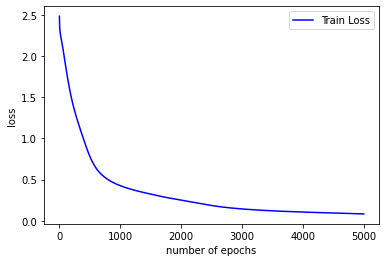

In [9]:
  fig = plt.figure()
  plt.plot(range(0, no_epochs), train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of epochs')
  plt.ylabel('loss')

### 4. Model Evaluation

In [10]:
net.eval() # set network to evaluation mode
y_pred = net(test_x)
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 90.83333333333333%
